In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

df = pd.read_json('packageReachDiffsPopular.json', typ='series')

thresholdUp = 1000
thresholdDown = -1000

candidates = {}

for pkg, val in df.items():
    boosts = []
    spike = None
    fall = None
    if val != None:
        for r in val:
            diff = r['Diff']
            if diff > thresholdUp:
                spike = r['Time']
            if diff < thresholdDown and spike != None:
                fall = r['Time']
                boosts.append({'spike': spike, 'fall': fall})
                spike = None
                fall = None
    if boosts:
        candidates[pkg] = boosts

# print(json.dumps(candidates))
# print(candidates)

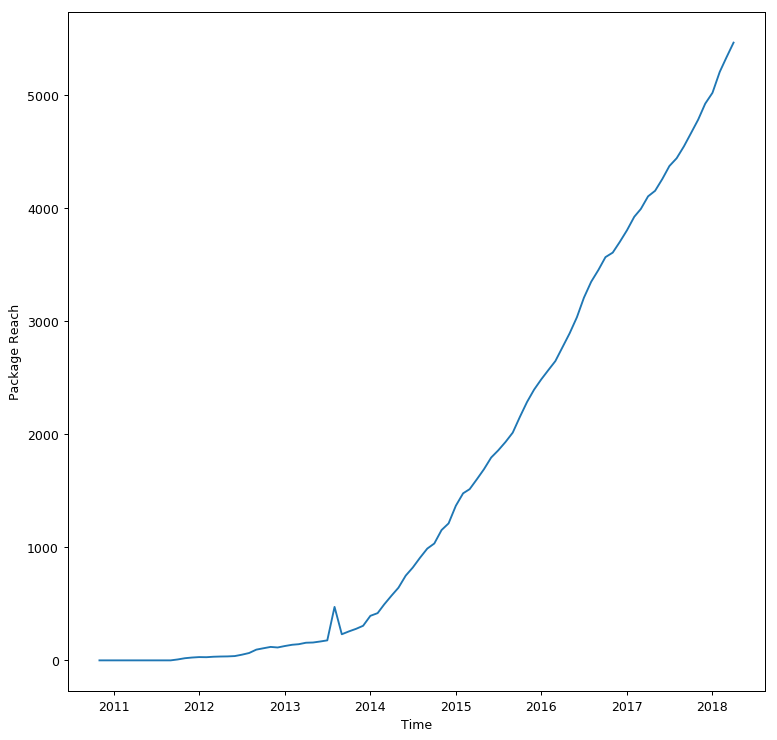

In [2]:
def setIndexToDate(df, avg):
    avg["Key"] = pd.to_datetime(avg["Key"])
    df = df.set_index(avg["Key"])
    return df

dataAvg = pd.read_json('maintainerReach/averageMaintainerReach.json')

packageName = 'event-stream'
packageFileName = packageName.replace('/', '')

# Package Reach for one Package
packageReach = pd.read_json('package-reach/{}/{}.json'.format(packageFileName[0], packageFileName))
packageReachDate = setIndexToDate(packageReach, dataAvg)
plt.figure(figsize=(10,10), dpi=90)
plt.xlabel('Time')
plt.ylabel('Package Reach')
plt.plot(packageReachDate["Y"])

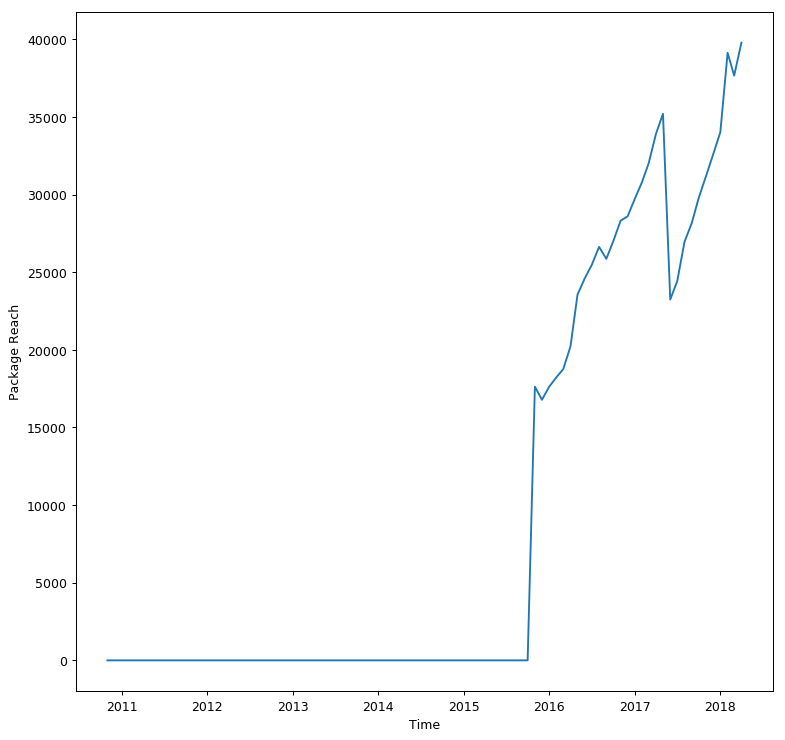

In [3]:
def setIndexToDate(df, avg):
    avg["Key"] = pd.to_datetime(avg["Key"])
    df = df.set_index(avg["Key"])
    return df

dataAvg = pd.read_json('maintainerReach/averageMaintainerReach.json')

packageName = 'wrap-ansi'
packageFileName = packageName.replace('/', '')

# Package Reach for one Package
packageReach = pd.read_json('popularityPackageReach/{}/{}.json'.format(packageFileName[0], packageFileName))
packageReachDate = setIndexToDate(packageReach, dataAvg)
plt.figure(figsize=(10,10), dpi=90)
plt.xlabel('Time')
plt.ylabel('Package Reach')
plt.plot(packageReachDate["Y"])

{'spike': '2017-05-01T00:00:00Z', 'fall': '2017-06-01T00:00:00Z'}
24430 20259.5834124 4170.41658763 0.205849079063


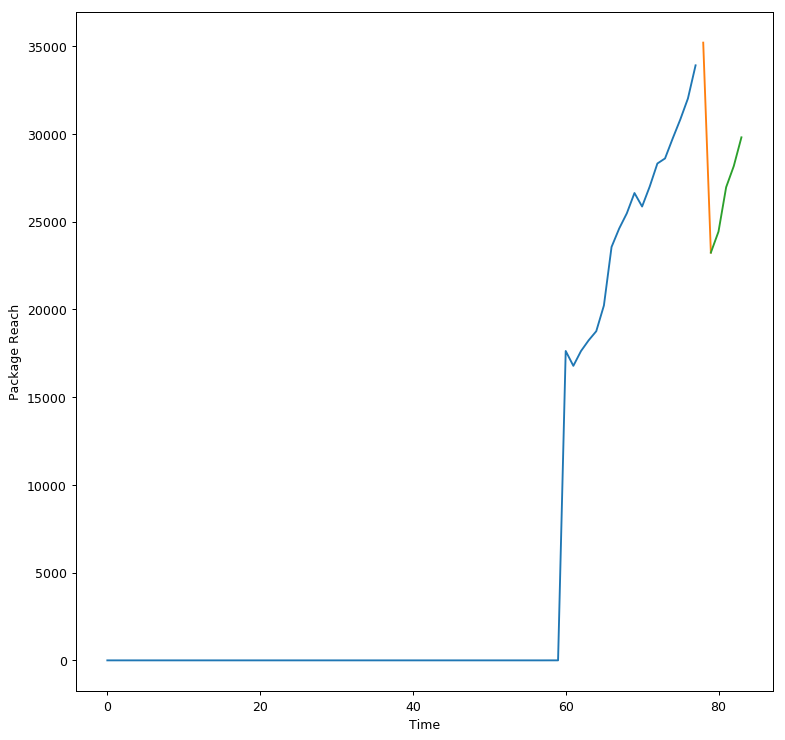

In [4]:
import numpy as np

boosts = candidates[packageName]
boost = boosts[0]
print(boost)

spike = pd.to_datetime(boost['spike'])
fall = pd.to_datetime(boost['fall'])
start = packageReachDate.loc[spike]['X']
end = packageReachDate.loc[fall]['X']

spikeLine = packageReach[0:start]
fallLine = packageReach[start:end+1]

# extrapolation
z = np.polyfit(spikeLine['X'], spikeLine['Y'], 1)
f = np.poly1d(z)
x_new = np.linspace(start, end+5, 10)
y_new = f(x_new)

# calculate boost factor
actual = packageReach.loc[end+1 if end+1 <= 89 else 89]['Y']
# adds normalize factor to avoid zero divison
normalizeFactor = 1
expected = f(end+1)
diff = actual - expected
boostFactor = diff / expected
print(actual, expected, diff, boostFactor)

after = packageReach[end:end+5]

plt.figure(figsize=(10,10), dpi=90)
plt.xlabel('Time')
plt.ylabel('Package Reach')
plt.plot(spikeLine['Y'])
plt.plot(fallLine['Y'])
plt.plot(after['Y'])

In [5]:
# calculate average boost factor
import numpy as np

boostFactors = []

for packageName, boosts in candidates.items():
    packageFileName = packageName.replace('/', '')

    # Package Reach for one Package
    packageReach = pd.read_json('popularityPackageReach/{}/{}.json'.format(packageFileName[0], packageFileName))
    packageReachDate = setIndexToDate(packageReach, dataAvg)

    boost = boosts[0]
    spike = pd.to_datetime(boost['spike'])
    fall = pd.to_datetime(boost['fall'])
    start = packageReachDate.loc[spike]['X']
    end = packageReachDate.loc[fall]['X']

    spikeLine = packageReach[0:start]
    fallLine = packageReach[start:end+1]

    # extrapolation
    z = np.polyfit(spikeLine['X'], spikeLine['Y'], 1)
    f = np.poly1d(z)
    x_new = np.linspace(start, end+5, 10)
    y_new = f(x_new)

    # calculate boost factor
    actual = packageReach.loc[end+1 if end+1 <= 89 else 89]['Y']
    # adds normalize factor to avoid zero divison
    normalizeFactor = 1
    expected = f(end+1)
    diff = actual - expected
    
    if expected == 0:
        continue
    
    boostFactor = diff / expected
    
    if boostFactor >= 1:
        continue
        print(packageName, boost, diff, expected, boostFactor)
    
    boostFactors.append(boostFactor)
    
# print(boostFactors)

309


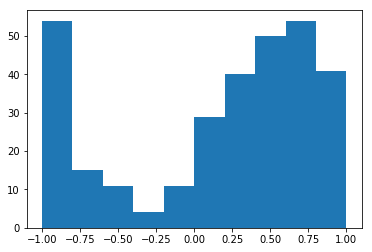

In [6]:
n_bins = 1
y = np.array(boostFactors)

# Plot histogram of average import usage
plt.hist(boostFactors)

print(len(boostFactors))